# Semantic chunk score exploration

Now that we have some of the semantic chunk data scored for perplexity ratio, let's take a look and see what we are working with.

## Notebook setup

In [1]:
# Change working directory to parent so we can import as we would from the perplexity ratio score root directory
%cd ..

# PyPI imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
from statistics import mean
from scipy.stats import ttest_ind

# Internal imports
import configuration as config
import notebooks.helper_functions.plotting_functions as plot_funcs

# Dots per inch for plot saving
plot_dpi=300

/home/siderealyear/projects/llm_detector/perplexity_ratio_score


## 1. Data loading

In [2]:
data_file=f'{config.SCORED_DATA_PATH}/test_chunks.47.parquet'
data_df=pd.read_parquet(data_file)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182484 entries, 0 to 182483
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Text                    182484 non-null  object 
 1   Synthetic               182484 non-null  int64  
 2   Author                  182484 non-null  object 
 3   Source                  182484 non-null  object 
 4   Text length (words)     182484 non-null  int64  
 5   Text length (tokens)    182470 non-null  float64
 6   Perplexity              182470 non-null  float64
 7   Cross-perplexity        182470 non-null  float64
 8   Perplexity ratio score  182470 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 12.5+ MB


In [3]:
data_df.head(10)

,Text,Synthetic,Author,Source,Text length (words),Text length (tokens),Perplexity,Cross-perplexity,Perplexity ratio score
0,Among the problems that occurred on that eve i...,0,Human,Grinberg,20,22.0,3.539062,4.578125,0.773038
1,TKT children will start to think it is okay to...,0,Human,Gerami,12,14.0,4.734375,4.316406,1.096833
2,"Cultural disposition, according to Campbell & ...",0,Human,Yatsenko,10,17.0,3.449219,3.451172,0.999434
3,According to Barack and Clow (9) advertising h...,0,Human,Grinberg,19,28.0,3.916016,3.347656,1.169778
4,The Allure of Hacking,0,Human,Grinberg,4,6.0,3.994141,5.410156,0.738267
5,"The Bitcoin Association, founded in London in ...",1,Unknown model,Yatsenko,11,14.0,3.253906,2.994141,1.086758
6,Jane and Josh later died when the Nazi army ma...,0,Human,Yatsenko,18,23.0,4.496094,4.214844,1.066728
7,"When you drink alcohol, it can cause dehydrati...",1,Unknown model,Yatsenko,73,81.0,1.843750,2.775391,0.664321
8,Does cOCH5B2 serve as a target antigen for ant...,1,GPT-3.5-turbo,Gaggar,18,26.0,3.664062,3.710938,0.987368
9,time I think about it...,1,Unknown model,Grinberg,5,6.0,3.849609,4.679688,0.822621


## 2. Data cleaning

In [4]:
# Check for NANs
print(f'{len(data_df)} total rows\n')
data_df.isna().sum()

182484 total rows



Text                       0
Synthetic                  0
Author                     0
Source                     0
Text length (words)        0
Text length (tokens)      14
Perplexity                14
Cross-perplexity          14
Perplexity ratio score    14
dtype: int64

In [5]:
# Inspect NANs, if any
data_df[data_df.isnull().any(axis=1)]

,Text,Synthetic,Author,Source,Text length (words),Text length (tokens),Perplexity,Cross-perplexity,Perplexity ratio score
14759,care at LA's...\nJoni Mitchell was rushed to t...,1,LLaMA2-13B,Hans,377,NaN,NaN,NaN,NaN
16423,"Schools, neighborhoods and businesses were seg...",0,Human,Yatsenko,389,NaN,NaN,NaN,NaN
27003,BALTIMORE (WJZ) — Baltimore officials are revi...,1,Unknown model,Yatsenko,396,NaN,NaN,NaN,NaN
28578,Solitude. \n \n That's one word that would des...,0,Human,Yatsenko,309,NaN,NaN,NaN,NaN
28706,Author/ Date ...,0,Human,Grinberg,343,NaN,NaN,NaN,NaN
43270,Table 10: Gantt chart of Zurich Financial Serv...,0,Human,Yatsenko,299,NaN,NaN,NaN,NaN
53283,"This page is a collection of Tech Manuals, Ser...",0,Human,Yatsenko,375,NaN,NaN,NaN,NaN
72639,the south - east region consists of three pari...,0,Human,Hans,472,NaN,NaN,NaN,NaN
82382,Chukchi (Ԓыгъоравэтԓьэн йиԓыйиԓ)\n\nChukchi is...,0,Human,Yatsenko,319,NaN,NaN,NaN,NaN
85010,The first few months of the 2014 draft class w...,1,Unknown model,Yatsenko,372,NaN,NaN,NaN,NaN


In [6]:
# And remove them
data_df.dropna(inplace=True)

# Check the result
print(f'{len(data_df)} total rows\n')
data_df.isna().sum()

182470 total rows



Text                      0
Synthetic                 0
Author                    0
Source                    0
Text length (words)       0
Text length (tokens)      0
Perplexity                0
Cross-perplexity          0
Perplexity ratio score    0
dtype: int64

In [7]:
# Remove any duplicate rows
data_df.drop_duplicates(inplace=True)

# Check the result
print(f'{len(data_df)} total rows')

182016 total rows


## 3. Data composition

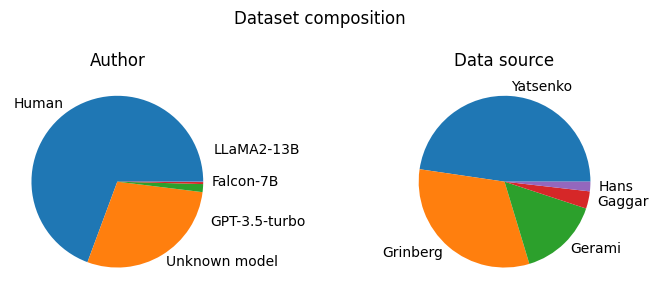

In [8]:
plot_obj=plot_funcs.data_composition(data_df)
plot_obj.savefig(f'{config.PLOT_PATH}/07-2_data_composition.jpg', dpi=plot_dpi)
plot_obj.show()

## 4. Text length

In [9]:
data_df['Text length (words)'].describe()

count    182016.000000
mean         29.859210
std          47.570486
min           2.000000
25%          11.000000
50%          15.000000
75%          27.000000
max         486.000000
Name: Text length (words), dtype: float64

### 4.1. Length distributions: all text

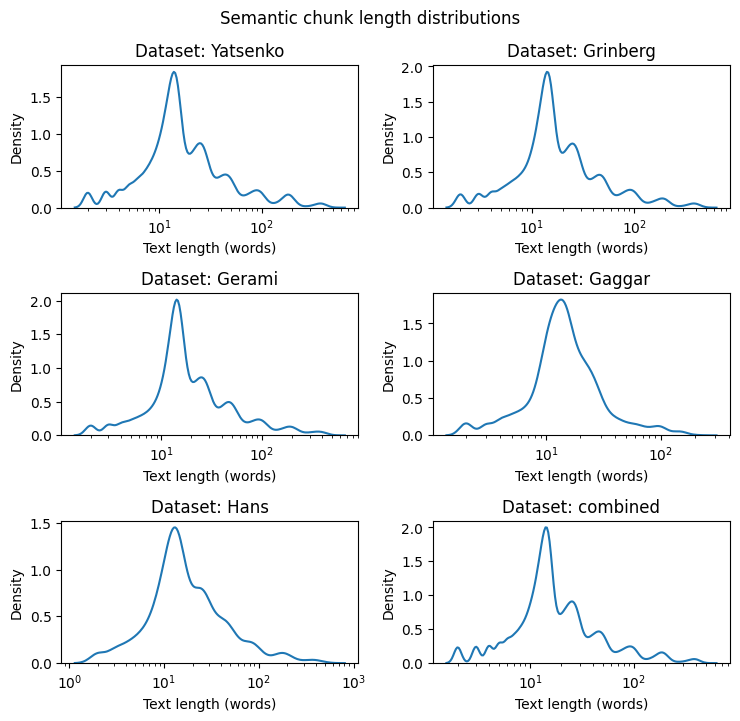

In [10]:
plot_obj=plot_funcs.length_distributions('Semantic chunk length distributions', data_df)
plot_obj.savefig(f'{config.PLOT_PATH}/07-4.1_semantic_chunk_length_distributions.jpg', dpi=plot_dpi)
plot_obj.show()

Just for fun, let's take a look at the chunk length distributions for human vs machine text.

### 4.2. Length distributions: human vs synthetic

In [11]:
# Replace int values for 'synthetic' with human readable strings
working_data_df=data_df.copy()
working_data_df['Synthetic']=data_df['Synthetic'].map({0: 'Human', 1: 'Synthetic'})
working_data_df.head()

,Text,Synthetic,Author,Source,Text length (words),Text length (tokens),Perplexity,Cross-perplexity,Perplexity ratio score
0,Among the problems that occurred on that eve i...,Human,Human,Grinberg,20,22.0,3.539062,4.578125,0.773038
1,TKT children will start to think it is okay to...,Human,Human,Gerami,12,14.0,4.734375,4.316406,1.096833
2,"Cultural disposition, according to Campbell & ...",Human,Human,Yatsenko,10,17.0,3.449219,3.451172,0.999434
3,According to Barack and Clow (9) advertising h...,Human,Human,Grinberg,19,28.0,3.916016,3.347656,1.169778
4,The Allure of Hacking,Human,Human,Grinberg,4,6.0,3.994141,5.410156,0.738267


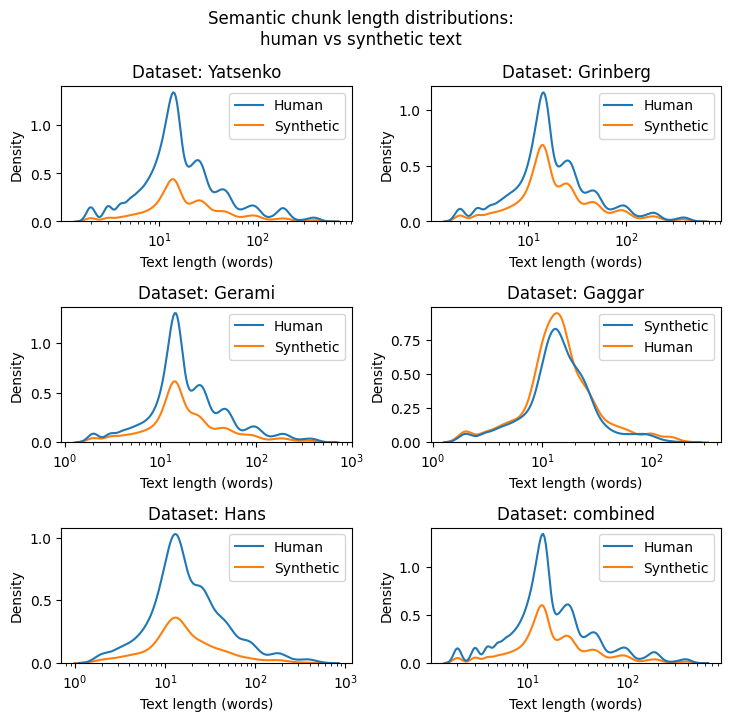

In [12]:
plot_obj=plot_funcs.length_distributions(
    'Semantic chunk length distributions:\nhuman vs synthetic text',
    working_data_df, 
    hue_by='Synthetic'
)

plot_obj.savefig(f'{config.PLOT_PATH}/07-4.2_human_vs_synthetic_length_distributions.jpg', dpi=plot_dpi)
plot_obj.show()

Both distributions plots look qualitatively similar to those generated from the complete dataset prior to scoring.

### 4.3. Word length vs token length

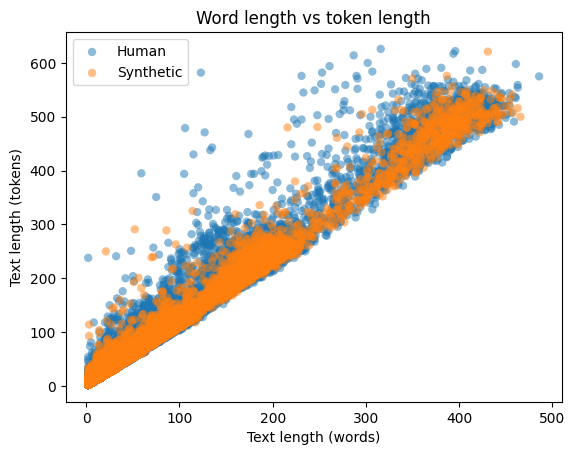

In [13]:
# Split the data into human and synthetic for plotting
human_df=working_data_df[working_data_df['Synthetic'] == 'Human']
synthetic_df=working_data_df[working_data_df['Synthetic'] == 'Synthetic']

plt.title('Word length vs token length')
plt.scatter(
    human_df['Text length (words)'],
    human_df['Text length (tokens)'],
    alpha=0.5,
    edgecolors='none',
    label='Human'
)
plt.scatter(
    synthetic_df['Text length (words)'],
    synthetic_df['Text length (tokens)'],
    alpha=0.5,
    edgecolors='none',
    label='Synthetic'
)
plt.xlabel('Text length (words)')
plt.ylabel('Text length (tokens)')
plt.legend(loc='upper left')
plt.savefig(f'{config.PLOT_PATH}/07-4.3_word_length_vs_token_length.jpg', dpi=plot_dpi)
plt.show()

Ok, nothing obviously pathological here - length in tokens is highly correlated with length in words and the token length tends to be a bit longer than the work length, as expected. I think the human text has slightly longer per word token length though... let's take a closer look.

### 4.4. Tokens per word ratio distributions: human vs synthetic text

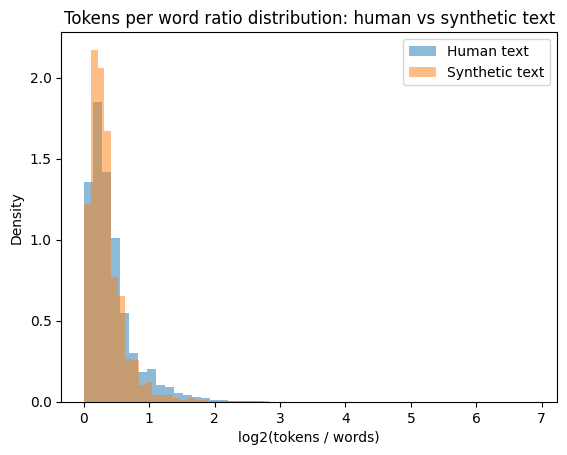

In [14]:
human_token_word_ratios=human_df['Text length (tokens)'] / human_df['Text length (words)']
synthetic_token_word_ratios=synthetic_df['Text length (tokens)'] / synthetic_df['Text length (words)']

plt.title('Tokens per word ratio distribution: human vs synthetic text')
plt.hist(np.log2(human_token_word_ratios), density=True, label='Human text', bins=50, alpha=0.5)
plt.hist(np.log2(synthetic_token_word_ratios), density=True, label='Synthetic text', bins=50, alpha=0.5)
plt.xlabel('log2(tokens / words)')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.savefig(f'{config.PLOT_PATH}/07-4.4_token_word_length_ratio_distributions.jpg', dpi=plot_dpi)
plt.show()

### 4.5. Tokens per word ratio as a function of word length

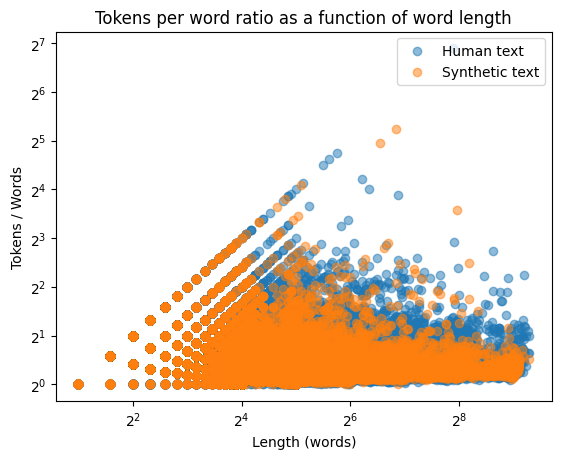

In [15]:
plt.title('Tokens per word ratio as a function of word length')
plt.scatter(human_df['Text length (tokens)'], human_token_word_ratios, label='Human text', alpha=0.5)
plt.scatter(synthetic_df['Text length (tokens)'], synthetic_token_word_ratios, label='Synthetic text', alpha=0.5)
plt.xlabel('Length (words)')
plt.ylabel('Tokens / Words')
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.legend(loc='upper right')
plt.savefig(f'{config.PLOT_PATH}/07-4.5_token_word_length_ratio_by_word_length.jpg', dpi=plot_dpi)
plt.show()

Maybe we are onto something. Human text consistently has the highest token/word ratio for a given text length. But, the bulk of the distributions are on top of each other. Let's take a look at what happens to the distribution plots when we normalize by the word length.

### 4.6. Normalized token word ratio distribution

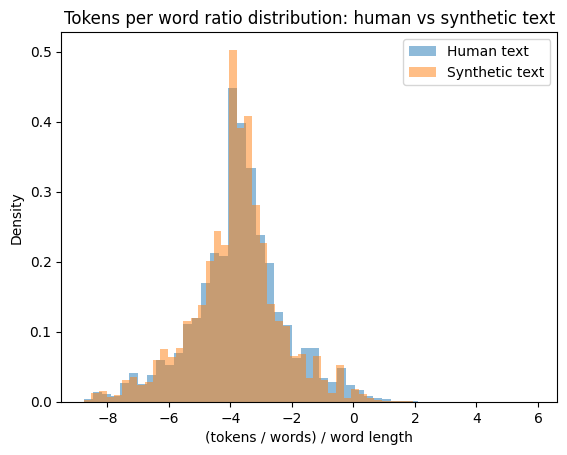

In [16]:
normalized_human_token_word_ratios=human_token_word_ratios / human_df['Text length (words)']
normalized_synthetic_token_word_ratios=synthetic_token_word_ratios / synthetic_df['Text length (words)']

plt.title('Tokens per word ratio distribution: human vs synthetic text')
plt.hist(np.log2(normalized_human_token_word_ratios), density=True, label='Human text', bins=50, alpha=0.5)
plt.hist(np.log2(normalized_synthetic_token_word_ratios), density=True, label='Synthetic text', bins=50, alpha=0.5)
plt.xlabel('(tokens / words) / word length')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.savefig(f'{config.PLOT_PATH}/07-4.6_normalized_token_word_length_ratio_distributions.jpg', dpi=plot_dpi)
plt.show()

Eh, maybe not. This is not convincing enough for a new feature. There is clearly some kind of difference present for a small fraction of the data, but I don't have a good way to pull it out right now. The model will see the word and token lengths anyway, so let's leave it alone for now and move on.

## 5. Perplexity ratio score

### 5.1. Human vs synthetic mean by dataset source

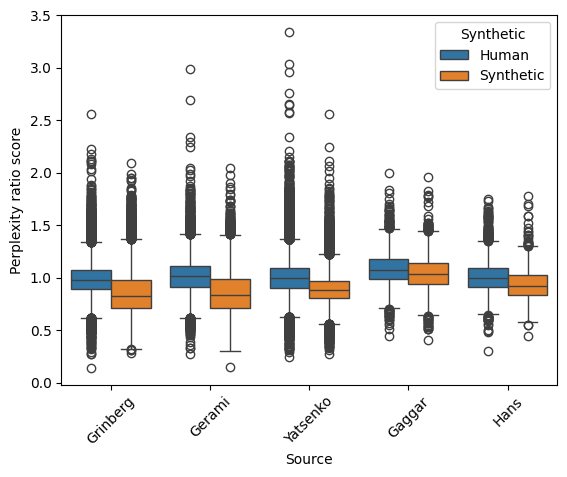

In [17]:
ax=sns.boxplot(data=working_data_df, x='Source', y='Perplexity ratio score', hue='Synthetic')
ax.tick_params(axis='x', labelrotation=45)
plt.savefig(f'{config.PLOT_PATH}/07-5.1_perplexity_ratio_score_mean_by_dataset_source.jpg', dpi=plot_dpi)
plt.show()

OK - cool! Looks qualitatively similar to the original Hans dataset by itself. Means are pretty clearly different, but there is a lot of overlap between the distributions. 

It's interesting that the Gaggar dataset seems the least differentiated and scores highest overall. That dataset contains GPT-3.5-turbo output, which is the most powerful adversary model in the dataset. But, the data was also created by prompting the model to rephrase human written text. This is different than purely generated responses.

Let's do a t-test and set-up a confidence interval around the difference in means to find out a little more quantitatively how different the two distributions actually are.

### 5.2. Human vs synthetic mean by author

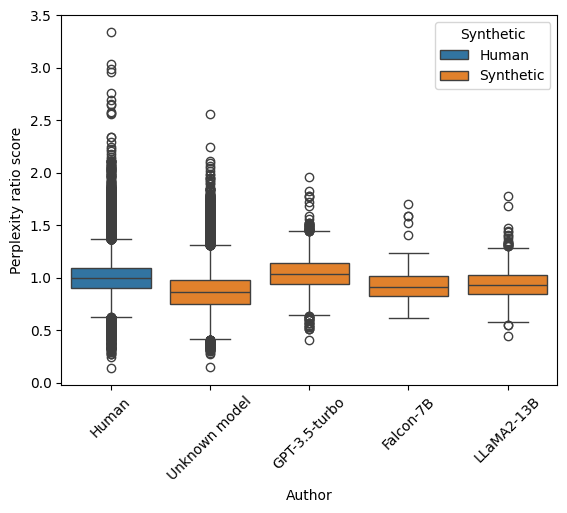

In [18]:
ax=sns.boxplot(data=working_data_df, x='Author', y='Perplexity ratio score', hue='Synthetic')
ax.tick_params(axis='x', labelrotation=45)
plt.savefig(f'{config.PLOT_PATH}/07-5.2_perplexity_ratio_score_mean_by_author.jpg', dpi=plot_dpi)
plt.show()

Same observations as above apply. Perplexity score mean is lower for synthetic text on average. The only model the output of which we are not convincingly detecting in aggregate is GPT-3.5-turbo, but again this is a 'rephrasing' dataset, not a *de novo* machine generated text dataset.

The only real solution to that kind of nit-picking is to synthesize our own data using a selection of different models. Problem will be the cost of using proprietary APIs to do so. No one is gonna take us seriously if we can't detect the newest, fanciest chatGPT.

For now, we can just exclude the Gagger data on the basis of how it was generated if it drags the dataset wide accuracy down too much.

In [19]:
# Pull the data for this model
human=human_df['Perplexity ratio score']
synthetic=synthetic_df['Perplexity ratio score']

# Get the means in question and their difference
human_mean=mean(human)
synthetic_mean=mean(synthetic)
mean_diff=human_mean - synthetic_mean

# Get the confidence interval
cm=sms.CompareMeans(sms.DescrStatsW(human), sms.DescrStatsW(synthetic))
difference=cm.tconfint_diff(usevar='unequal')
low_bound=difference[0]
high_bound=difference[1]

# Do a t-test with H0 equal means, H1 human greater than synthetic
ttest_result = ttest_ind(human, synthetic, alternative='greater')

print(f'T-test p-value = {ttest_result.pvalue}')
print(f'Difference in means = {mean_diff:.3f}, 95% CI = ({low_bound:.3f}, {high_bound:.3f})')

T-test p-value = 0.0
Difference in means = 0.119, 95% CI = (0.117, 0.120)


Good, marginally better even. Just for reference - here is the Falcon-7B reader/writer result for the old Hans only dataset:

```
Model: Falcon-7B, t-test p-value = 1.468072030319169e-94
Model: Falcon-7B, difference in means = 0.116, 95% CI = (0.106, 0.126)
```

### 5.3. Human vs synthetic distribution

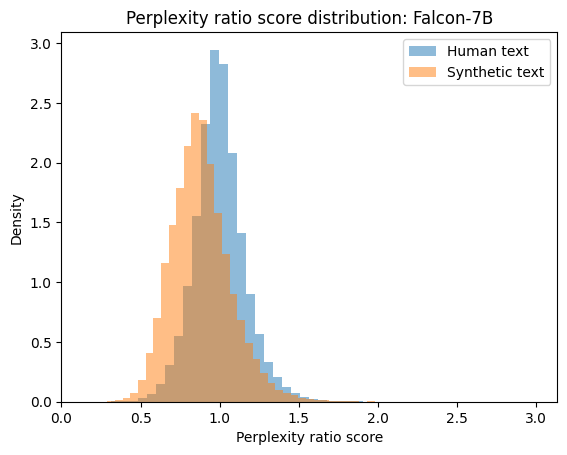

In [20]:
# Threshold the data for plotting
human_df=human_df[human_df['Perplexity ratio score'] < 3]
synthetic_df=synthetic_df[synthetic_df['Perplexity ratio score'] < 3]

plt.title('Perplexity ratio score distribution: Falcon-7B')
plt.hist(human_df['Perplexity ratio score'], density=True, label='Human text', bins=50, alpha=0.5)
plt.hist(synthetic_df['Perplexity ratio score'], density=True, label='Synthetic text', bins=50, alpha=0.5)
plt.xlabel('Perplexity ratio score')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.savefig(f'{config.PLOT_PATH}/07-5.3_perplexity_ratio_score_distribution.jpg', dpi=plot_dpi)
plt.show()

### 5.4. Perplexity ratio score by text length

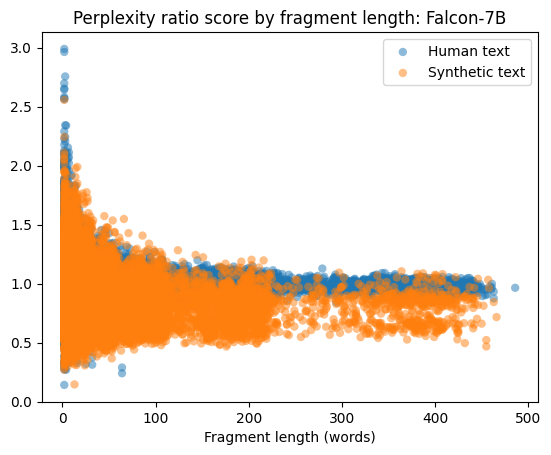

In [21]:
plt.title('Perplexity ratio score by fragment length: Falcon-7B')
plt.scatter(
    human_df['Text length (words)'],
    human_df['Perplexity ratio score'],
    alpha=0.5,
    edgecolors='none',
    label='Human text'
)
plt.scatter(
    synthetic_df['Text length (words)'],
    synthetic_df['Perplexity ratio score'],
    alpha=0.5,
    edgecolors='none',
    label='Synthetic text'
)
plt.xlabel('Fragment length (words)')
plt.legend(loc='upper right')
plt.savefig(f'{config.PLOT_PATH}/07-5.4_perplexity_ratio_score_by_text_length.jpg', dpi=plot_dpi)
plt.show()

Also, on the whole, very similar to the Hans data alone. Even if the fact that the gagger synthetic GPT data seems to score similarly to human is slightly concerning, it's good news that overall our trick seems to work well on data from other sources.